In [ ]:
import ML_Veterinray_Metrics_Func as vet
import os
import shutil

In [ ]:
path_target = "/home/data/data/kodeiri/ML_project/dogs datasets/Blind/"
path_src = "/home/data/data/kodeiri/ML_project/dogs datasets/Sick_dogs/"
i=0
for folder in (os.listdir(path_src)):
    src1 = path_src  + folder
    if folder == '.DS_Store':
        os.remove(src1)
        continue
    for folder2 in (os.listdir(src1)):
        src2 = src1 +'/'+ folder2
        if folder2 == '.DS_Store':
                os.remove(src2)
                continue
        for file in os.listdir(src2):
            
            src3 = src2 + '/' + file
            if file == '.DS_Store':
                os.remove(src3)
                continue
            dst = path_target  + file
            print(src3)
            print(dst)
            shutil.copy (src3,dst)
            i +=1
            print(i)


#vet.img_preprocess()

In [ ]:
vet.img_preprocess("/home/data/data/kodeiri/ML_project/dogs datasets/Blind/","/home/data/data/kodeiri/ML_project/dogs datasets/Blind_thrash/")

Prediction: Adult
Confidence: 0.99976605
Ground_truth: Adult
Prediction: Young
Confidence: 0.92364097
Ground_truth: Adult
Prediction: Adult
Confidence: 0.9785338
Ground_truth: Adult
Prediction: Adult
Confidence: 0.47387835
Ground_truth: Adult


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: Adult
Confidence: 0.992343
Ground_truth: Adult


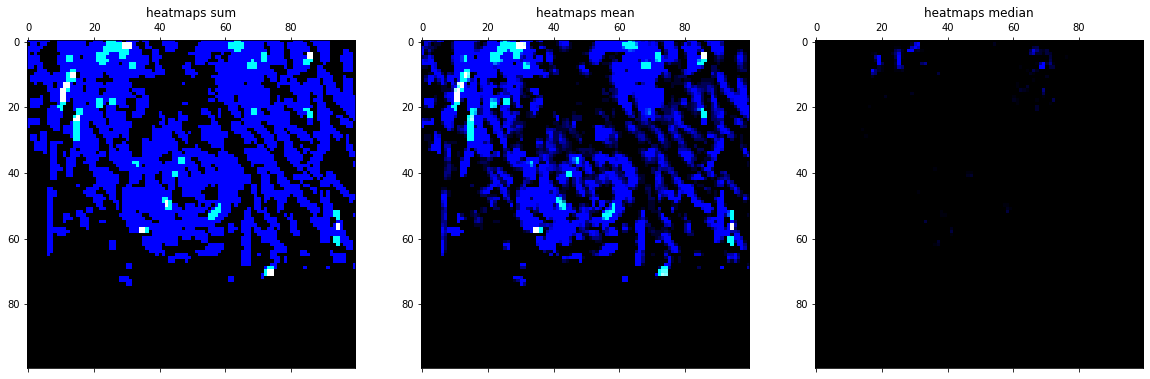

4


In [3]:
hm,sm, mn, md = vet.predict_on_examples(
    "/home/data/data/kodeiri/ML_project/dogs datasets/Blind/",
    "Adult",
    display_image=False,
    display_heatmap=False,
    display_template = True,
    iteration_number = 0)